# Imports

In [1]:
import copy
import numpy as np
import os
from os.path import join
import scipy.io
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy import signal
from skimage.transform import resize
import seaborn as sb
import scikit_posthocs as sp
import itertools
import pingouin as pg

C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Utility functions

In [2]:
"""
Functions that imitate the behavior of the functions fixations_3s and fixations_t2 of the EyeMMV Toolbox
https://github.com/krasvas/EyeMMV

Further, functions to reduce dataframes by condition, filter by stimulus and mask area, and statisical analysis of reduced dataframes.
"""
def t1_criterion(coordinates, t1 = 17):

    nb_rows = coordinates.shape[0]
    fixations = np.zeros(nb_rows)

    # Fixation id
    fixid = 1

    # Fixation counter
    fixpointer = 0

    for i in range(nb_rows):

        mean = coordinates[fixpointer:i+1, :].mean(axis=0)
        di = np.linalg.norm(stimuli_coordinates[i, :] - mean)

        if di > t1:
            fixid += 1
            fixpointer = i

        fixations[i] = fixid

    return fixations

def distance2p(x1,y1,x2,y2):
    dx = x2-x1
    dy = y2-y1
    return np.sqrt(dx**2+dy**2)

def fixations_t2(fixations, fixation_id, t2):
    n = fixations.shape[0] # number of all points
    fixations_id = np.zeros((1, 4))

    for i in range(n):
        if fixations[i, 3] == fixation_id:
            fixations_id = np.vstack((fixations_id, fixations[i]))

    fixations_id = fixations_id[1:] # list of data points with the defined id

    # clustering according to criterion t2
    number_t1 = fixations_id.shape[0]
    x = fixations_id[:, 0]
    y = fixations_id[:, 1]
    fixx = np.mean(fixations_id[:, 0])
    fixy = np.mean(fixations_id[:, 1])

    for i in range(number_t1):
        d = distance2p(x[i], y[i], fixx, fixy)
        if d > t2:
            fixations_id[i, 3] = 0

    # initialize new list (data points according to t2)
    fixations_list_t2 = np.zeros((1, 4))

    # initialize list of points which are not used after t2 criterion
    list_out_points = np.zeros((1, 4))

    # Filter the points that are outside of region and the ones that are inside
    for i in range(number_t1):
        if fixations_id[i, 3] > 0:
            fixations_list_t2 = np.vstack((fixations_list_t2, fixations_id[i]))
        else:
            list_out_points = np.vstack((list_out_points, fixations_id[i]))

    fixations_list_t2 = fixations_list_t2[1:]
    number_t2 = fixations_list_t2.shape[0]

    # Construct mean of points that are within region around mean
    fixx = np.mean(fixations_list_t2[:, 0])
    fixy = np.mean(fixations_list_t2[:, 1])

    if number_t2 > 0:
        start_time = fixations_list_t2[0, 2]
        # End time is the last sample that is included, for iterations add 1
        end_time = fixations_list_t2[number_t2 - 1, 2]
        duration = fixations_list_t2[number_t2 - 1, 2] - fixations_list_t2[0, 2]
    else:
        start_time = 0
        end_time = 0
        duration = 0

    # Remove dummy init
    list_out_points = list_out_points[1:]
    # Number of out points
    n_out = list_out_points.shape[0]

    if n_out > 1:
        list_out_points = list_out_points[1:]
    else:
        list_out_points = np.array([[0, 0, 0, -1]]) # indicates that there are no points which are not used

    return fixx, fixy, number_t1, number_t2, start_time, end_time, duration, list_out_points
def min_duration(fixation_list, minDur=180):
    n = fixation_list.shape[0]

    # initialize new fixation list
    fixations = np.zeros((1, 7))
    for i in range(n):
        if fixation_list[i, 6] > minDur:
            fixations = np.vstack((fixations, fixation_list[i]))

    fixations = fixations[1:]

    return fixations
def fixations_3s(fixations, fixation_id):
    n = fixations.shape[0] # number of all points
    fixations_id = np.zeros((1, 4))

    for i in range(n):
        if fixations[i, 3] == fixation_id:
            fixations_id = np.vstack((fixations_id, fixations[i]))

    fixations_id = fixations_id[1:] # list of data points with the defined id

    # clustering according to criterion 3s
    number_t1 = fixations_id.shape[0]
    x = fixations_id[:, 0]
    y = fixations_id[:, 1]
    fixx = np.mean(fixations_id[:, 0])
    fixy = np.mean(fixations_id[:, 1])
    sx = np.std(x)
    sy = np.std(y)
    s = np.sqrt(sx**2 + sy**2)

    for i in range(number_t1):
        d = distance2p(x[i], y[i], fixx, fixy)
        if d > 3 * s:
            fixations_id[i, 3] = 0

    # initialize new list (data points according to 3s criterion)
    fixations_list_3s = np.zeros((1, 4))

    for i in range(number_t1):
        if fixations_id[i, 3] > 0:
            fixations_list_3s = np.vstack((fixations_list_3s, fixations_id[i]))

    fixations_list_3s = fixations_list_3s[1:]
    number_3s = fixations_list_3s.shape[0]
    fixx = np.mean(fixations_list_3s[:, 0])
    fixy = np.mean(fixations_list_3s[:, 1])
    start_time = fixations_list_3s[0, 2]
    end_time = fixations_list_3s[number_3s - 1, 2]
    duration = fixations_list_3s[number_3s - 1, 2] - fixations_list_3s[0, 2]

    return fixx, fixy, number_t1, number_3s, start_time, end_time, duration


def refine_fixations(coords, fixations, t2=17, mindur=180):

    t2_fixations = np.zeros((int(fixations[-1]), 7))

    three_s_fixations = np.zeros((int(fixations[-1]), 7))

    counter = np.arange(coords.shape[0])
    addon = np.vstack((counter, fixations)).T
    fixations_as_matlab = np.hstack((coords, addon))

    for i in range(1, int(fixations[-1]) + 1):

            # t2 criterion
            t2_values = fixations_t2(fixations_as_matlab, i, t2=t2)
            t2_fixations[i-1, :] = np.array(t2_values[:-1])

            # 3s criterion
            three_s_values = fixations_3s(fixations_as_matlab, i)
            three_s_fixations[i-1, :] = np.array(three_s_values)

    fixations_t2_filtered = min_duration(t2_fixations, minDur=mindur)
    fixations_3s_filtered = min_duration(three_s_fixations, minDur=mindur)

    return fixations_t2_filtered, fixations_3s_filtered

def return_equiv_vid_frames(start, dur):

    samples_per_frame = 2000/30

    first_index = np.floor(start/samples_per_frame)
    last_index = np.floor((start+dur)/samples_per_frame)

    return np.arange(first_index, last_index + 1, 1, dtype=int)

def fixations_filtering(fixations, masks, screen_area):
    """

    :param fixations: f3s or ft2 fixations
    :param masks: Image mask or video masks
    :param screen_area: Image or Video Screen Area
    :return:
    """

    in_img = []
    out_img = []
    in_filter = []
    out_filter = []

    for index in range(fixations.shape[0]):

        fx = fixations[index, 0]
        fy = fixations[index, 1]

        fy_in_img_space = int(fy - screen_area[0][0])
        fx_in_img_space = int(fx - screen_area[1][0])

        img_lim_x = screen_area[1][1] - screen_area[1][0]
        img_lim_y = screen_area[0][1] - screen_area[0][0]

        if 0 <= fx_in_img_space < img_lim_x and 0 <= fy_in_img_space < img_lim_y:
            in_img.append(index)

            # Further filtering with masks
            in_mask = True

            if masks.ndim < 3:
                if not masks[fy_in_img_space, fx_in_img_space]:
                    in_mask = False

            else:
                start = fixations[index, 4]
                dur = fixations[index, 6]
                vid_mask_indices = return_equiv_vid_frames(start, dur)
                #print(f"{index}: {vid_mask_indices}")
                for vid_mask_index in vid_mask_indices:
                    vid_mask_frame = masks[vid_mask_index, :, :]

                    if not vid_mask_frame[fy_in_img_space, fx_in_img_space]:
                        in_mask = False

            if in_mask:
                in_filter.append(index)
            else:
                out_filter.append(index)

        else:
            out_img.append(index)

    return in_img, out_img, in_filter, out_filter

def samples_in_stim(stimuli_coords, masks, screen_area):
    
    # Return samples that are within image and monkey
    
    in_image = 0
    in_monkey = 0
    image_origin = [screen_area[1][0], screen_area[0][0]]

    in_image_coords = stimuli_coords - np.array(image_origin)

    img_lim_x = screen_area[1][1] - screen_area[1][0]
    img_lim_y = screen_area[0][1] - screen_area[0][0]

    #print(img_lim_y)
    #print(img_lim_x)

    samples_per_frame = 2000/30

    for index, (x, y) in enumerate(in_image_coords):

        if (0<=x<=img_lim_x) and (0<=y<=img_lim_y):
            in_image += 1

            # Image mask
            if masks.ndim < 3:
                if masks[int(y), int(x)]:
                    in_monkey += 1

            # Video mask
            else:

                frame_index = np.floor(index/samples_per_frame)
                #print(int(frame_index))
                if masks[int(frame_index), int(y), int(x)]:
                    in_monkey += 1

    return [in_image, in_monkey]

def flatten(l):
    return [item for sublist in l for item in sublist]

def get_kernel_img_boundaries(x, y, image_size, kernel_size):

    lower_image_cap = kernel_size//2
    higher_image_cap = kernel_size - lower_image_cap

    low_y = y-lower_image_cap
    high_y = y+higher_image_cap
    low_x = x-lower_image_cap
    high_x = x+higher_image_cap

    low_x_kernel = 0
    low_y_kernel = 0
    high_x_kernel = kernel_size
    high_y_kernel = kernel_size

    if low_y < 0:
        low_y_kernel = -1*low_y
        low_y = 0

    if low_x < 0:
        low_x_kernel = -1*low_x
        low_x = 0

    if high_x > image_size:
        high_x_kernel = image_size - high_x
        high_x = image_size

    if high_y > image_size:
        high_y_kernel = image_size - high_y
        high_y = image_size

    ys = [low_y, low_y_kernel, high_y, high_y_kernel]
    xs = [low_x, low_x_kernel, high_x, high_x_kernel]
    return ys, xs

def gkern(kernlen=21, std=3):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

def reduce_df_by_conditions(dataframe, trials=None, individual=None, action=None, view=None, vid=None, render=None, render_comb=None):
    """
    Reduces the data frame by conditions
    :param dataframe: The dataframe
    :param trials: Trials to take into consideration
    :param individual: The individual to take into consideration if given
    :param action: The action to take into consideration if given
    :param view: The view to take into consideration if given
    :param vid: The video type (static/dynamic) to take into consideration if given
    :param render: The render type to take into consideration if given
    :param render_comb: Combined renders to reduce if given
    :return: 
    """

    dataframe = copy.deepcopy(dataframe)

    if trials is not None:
        # Reduce trials
        dataframe = dataframe[dataframe['Trial'] < trials]

    if individual is not None:
        dataframe = dataframe[dataframe['Individual'] == individual]

    if vid is not None:
        dataframe = dataframe[dataframe['Video'] == vid]

    if render is not None:
        dataframe = dataframe[dataframe['Render'] == render]

    if action is not None:
        dataframe = dataframe[dataframe['Action'] == action]

    if view is not None:
        dataframe = dataframe[dataframe['View'] == view]

    if render_comb is not None:
        dataframe = dataframe[dataframe['Combined_Renders'] == render_comb]

    return dataframe

def reduce_df_by_conditions_special_trials(dataframe, trials=None, individual=None, action=None, view=None, vid=None, render=None, masking=None, render_comb=None):
    """
    Similar functionality to reduce_df_by_conditions
    :param dataframe: 
    :param trials: 
    :param individual: 
    :param action: 
    :param view: 
    :param vid: 
    :param render: 
    :param masking: In filter or in image as special condition
    :param render_comb: 
    :return: 
    """
    dataframe = copy.deepcopy(dataframe)

    if trials is not None:
        # Reduce trials
        dataframe = dataframe[dataframe['Trial'] == trials]

    if individual is not None:
        dataframe = dataframe[dataframe['Individual'] == individual]

    if vid is not None:
        dataframe = dataframe[dataframe['Video'] == vid]

    if render is not None:
        dataframe = dataframe[dataframe['Render'] == render]

    if action is not None:
        dataframe = dataframe[dataframe['Action'] == action]

    if view is not None:
        dataframe = dataframe[dataframe['View'] == view]

    if masking is not None:
        dataframe = dataframe[dataframe['Masking'] == masking]

    if render_comb is not None:
        dataframe = dataframe[dataframe['Combined_Renders'] == render_comb]

    return dataframe


def statistical_analysis_of_samples(dataframes, var1):
    """
    Create friedmansquare of dataframes
    :param dataframes: 
    :param var1: 
    :return: 
    """

    # Use friedmann and post-hoc dunn
    # Friedmann test
    print("Friedmannchisquare")

    if var1.__len__() == 5:
        stat, p = scipy.stats.friedmanchisquare(dataframes[0], dataframes[1], dataframes[2], dataframes[3], dataframes[4])
    elif var1.__len__() == 7:
        stat, p = scipy.stats.friedmanchisquare(dataframes[0], dataframes[1], dataframes[2], dataframes[3], dataframes[4], dataframes[5], dataframes[6])
    print('Statistics=%.3f, p=%.5f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
     print('Same distributions (fail to reject H0)')
    else:
     print('Different distributions (reject H0)')

    print("Post-hoc Dunn test:")
    # Benjamin Hochberg
    table = sp.posthoc_dunn(dataframes, p_adjust='fdr_bh') # or sidak
    print(table)

def mean_aggregation_individuals_rm_anova(dataframe, value="Fixations", var1=[None], var2=[None], trial=0, inds=[None], tr_caps = [None], coverage=False, masking="in_filter", var2_string="Video", analysis_path = r"L:\OneDrive - UT Cloud\Shared\Animation_validation\Uncanny\Experiment\ANALYSIS\MeanTables", pixel_offset=0, var1_string="Render"):
    """

    :param dataframe: Dataframe to calculate ANOVA over
    :param value: Dependent variable, measurement
    :param var1: First between subject factor
    :param var2: Second between subject factor
    :param trial: 0 (first trial), else (all trials by tr_caps) for fixation df; for coverage df, pass the appropriate string "first"/"all"
    :param inds: individuals participating in the analysis
    :param tr_caps: maximum number of trials per individual
    :param coverage: boolean if coverage dataframe is passed
    :param masking: only necessary if coverage is passed, indicating whether to check coverage in_filter or in_image f.ex.
    :return: ANOVA results and mean dataframe used for calculations.
    """

    # Make combinations
    product = list(itertools.product(var1, var2))
    print(f"Conditions for testing: {var1_string} and {var2_string}")
    print(product)


    # Create dataframes for means for pingouin
    if var2[0]:
        df_pg = pd.DataFrame(columns=["Individual", var1_string, var2_string, value])
    else:
        df_pg = pd.DataFrame(columns=["Individual", var1_string, value])

    if not coverage:
        if trial == 0:
            print("FIRST TRIAL RESULTS!!!")
        else:
            print("ALL TRIAL RESULTS!!!")

    #print(inds)
    # Create means over individuals
    for ind in inds:
        for r, v in product:
            means = []

            if coverage:

                if var2_string == "Video" and var1_string == "Render":
                    # If side condition is video, then it's reduced for the video
                    red_df_vid = reduce_df_by_conditions_special_trials(dataframe, vid=v, render=r, individual=ind, trials=trial, masking=masking)

                elif var2_string == "Action" and var1_string == "View":
                    # If side condition is video, then it's reduced for the video
                    red_df_vid = reduce_df_by_conditions_special_trials(dataframe, action=v, view=r, individual=ind, trials=trial, masking=masking)

                elif var2_string == "Action" and var1_string == "Render":
                    # If its not video as side condition we reduce the action, but by None

                    red_df_vid = reduce_df_by_conditions_special_trials(dataframe, action=v, render=r, individual=ind, trials=trial, masking=masking)

                means.append(red_df_vid[value].mean())
            else:
                for tr in range(tr_caps[ind]):

                    #print(tr)


                    if var2_string == "Video" and var1_string == "Render":
                        red_df_vid = reduce_df_by_conditions(dataframe, vid=v, render=r, individual=ind)

                    elif var2_string == "Action" and var1_string == "View":
                        red_df_vid = reduce_df_by_conditions(dataframe, action=v, view=r, individual=ind)

                    elif var2_string == "Action" and var1_string == "Render":
                        red_df_vid = reduce_df_by_conditions(dataframe, action=v, render=r, individual=ind)

                    elif var2_string == "Action" and var1_string == "Combined_Renders":
                        red_df_vid = reduce_df_by_conditions(dataframe, action=v, render_comb=r, individual=ind)



                    red_df_vid = red_df_vid[red_df_vid['Trial'] == tr]

                    means.append(red_df_vid[value].mean())
                    #print(means)
                    if trial == 0:

                        # Aggregate only for 0
                        break

            mean_of_means = np.mean(means)

            # Check that there are no NANs
            assert not np.isnan(mean_of_means)

            if var2[0]:
                # After this have mean fixations
                df_pg.loc[len(df_pg)] = [ind, r, v, mean_of_means]
            else:
                df_pg.loc[len(df_pg)] = [ind, r, mean_of_means]

    if var2[0]:
        # Save the analysis results
        csv_string = f"{value}_{var1_string}_{var2_string}_{trial}_{pixel_offset}_{masking}.csv"
        print(f"Data file named: {csv_string}")
        df_pg.to_csv(join(analysis_path, csv_string))
    else:
        # Save the analysis results
        csv_string = f"{value}_{var1_string}_{trial}_{pixel_offset}_{masking}.csv"
        print(f"Data file named: {csv_string}")
        df_pg.to_csv(join(analysis_path, csv_string))

    #print(df.head(3))
    print(var2[0])
    if var2[0]:
        print("Multiple Factor")
        res = pg.rm_anova(dv=value, within=[var1_string, var2_string], subject='Individual', data=df_pg, detailed=True)
    else:
        print("Single Factors")
        res = pg.rm_anova(dv=value, within=var1_string, subject='Individual', data=df_pg, detailed=True, correction=True)

        print(pg.sphericity(dv=value, within=var1_string, subject='Individual', data=df_pg))

        # Post hoc t tests
        print(pg.pairwise_ttests(dv=value, within=var1_string, subject='Individual', data=df_pg, correction=True, padjust="fdr_bh"))

    print(res)

    return res, df_pg

def pingouin_to_friedman_anova_(df, val, var1):
    """
    Make Friedman from pingouin compatible dataframe
    :param df: 
    :param val: 
    :param var1: 
    :return: 
    """
    reduced = df.drop('Individual', axis=1)[val].T.values.tolist()
    reduced = [reduced[i:i+len(var1)] for i in range(0, len(reduced), len(var1))]
    reduced = np.array(reduced).T.tolist()
    statistical_analysis_of_samples(reduced, var1)

## Load data

### Images, masks of videos and images

In [3]:
data_path = r"../data/UncannyValley/EyeMovementData"
data_files = [f for f in os.listdir(data_path) if 'eyedata' in f]
individuals = ["Gin", "Hyde", "Jekyll", "Nacho", "Tonic", "Odin", "Libre", "Cuba"]
actions = ["fear", "walk"]
renders = ["wireframe","gray", "color", "fur", "real"]


views = ["B", "C", "D", "E", "F", "G", "H"]

vid_conds = [0, 1]

all_stim_names = []

for action in actions:
    for render in renders:
        for view in views:
            for vid_cond in vid_conds:

                if vid_cond:
                    # Video
                    stim_cond = f"lummatch_{action}_{view}_{render}.avi"
                else:
                    # Image
                    frame_timing = ""
                    mask_timing = 0
                    if action == "fear":
                        frame_timing = "0035"
                        mask_timing = 39
                    else:
                        frame_timing = "0010"
                        mask_timing = 11

                     # Get the corresponding image
                    stim_cond = f"lm_{action}_{view}_{render}_{frame_timing}.png"
                all_stim_names.append(stim_cond)
# Screen size (1080, 1920)

# Images: 500, 500
# Location image matlab: y: 291-790 x: 711-1210
# Converted to numpy: y:290-790 x:710-1210

image_screen_area = [[290, 790], [710, 1210]]

# Videos: 496, 496
# Instead of 1080/2 = 540 -> + 500/2 --> 790
# 540 + 496/2 --> 788 and 292, 712-1208 respectively

video_screen_area = [[292, 788], [712, 1208]]
eye_data_individuals = {}

for ind in individuals:


    mat = scipy.io.loadmat(join(data_path, f"{ind}_eyedata.mat"))

    eye_data = mat['trials_xy']
    stimuli_unpacked = mat['c'][0]['Stimul']

    # Extract all the names into a list
    stimuli_names = [x[0][0][0] for x in stimuli_unpacked]


    # Create a mapping from stimuli names to rows indices

    # Stimuli to experiment correspondence
    stim_to_row = {}
    for stim_name in all_stim_names:
        search_indices = [i for i, x in enumerate(stimuli_names) if x == stim_name]
        stim_to_row[stim_name] = search_indices


    eye_data_individuals[ind] = [eye_data, stim_to_row, stimuli_names]
# Get trial caps
trial_caps = {}

for ind in individuals:
    # Count occurences of the stimuli in the whole session
    stim_trials = Counter(eye_data_individuals[ind][2]).values()
    trial_caps[ind] = min(stim_trials)
print(trial_caps)
# Load filters

stimuli_path = r"../data/UncannyValley/Stimuli/"

pixel_offset = 0
#pixel_offset = 10

with open(join(stimuli_path, f'image_masks_proc_{pixel_offset}.pkl'), 'rb') as f:
    image_masks = pickle.load(f)

with open(join(stimuli_path, f'video_masks_proc_{pixel_offset}.pkl'), 'rb') as f:
    vid_masks = pickle.load(f)


images_stimuli_path = join(stimuli_path, "images")

# Images path and image names

image_names = [f for f in os.listdir(images_stimuli_path) if '.png' in f]

# Load all images into a dict

images = {}
for image_name in image_names:
    images[image_name] = plt.imread(join(images_stimuli_path, image_name))

{'Gin': 9, 'Hyde': 10, 'Jekyll': 10, 'Nacho': 5, 'Tonic': 9, 'Odin': 3, 'Libre': 5, 'Cuba': 5}


## Create analysis across trials

In [4]:
# To recreate the analysis in the following, either load data or reanalyse eye fixations, default False due to processing time
recreate_analysis = False
# Number unique stimuli in the dataset
number_unique_stimuli = 140
# Hyperparameter
t2 = 17
# Min duration in samples
mindur = 180

if recreate_analysis:


    individuals_fixations = {}
    
    for ind in individuals:
        print(f"Ind {ind}")
        # Iterate over all subjects
        subject = ind
    
        exp_data = eye_data_individuals[subject]
    
        session_coordinates = exp_data[0]
        session_mapping = exp_data[1]
        session_stimuli = exp_data[2]
    
        ind_fixations = {}
    
        # Iterate over all trials
        for trial in range(trial_caps[subject]):
            print(f"Trial {trial}")
    
            trial_fixations = {}
    
            # 0-indexed
            selected_trial = trial
    
            assert selected_trial < trial_caps[subject]
    
    
            start = number_unique_stimuli*selected_trial
            end = number_unique_stimuli*(selected_trial+1)
    
            trial_stimuli = session_stimuli[start:end]
            #trial_coordinates = session_coordinates[:,:,start:end]
    
            counts = Counter(trial_stimuli).values()
            # Check that for the trial there are no multiples
            assert min(counts) == 1
            # Check that all are shown
            assert counts.__len__() == number_unique_stimuli
    
    
            # Iterate over conditions
            actions = ["fear", "walk"]
            renders = ["gray", "fur", "wireframe", "real", "color"]
            views = ["B", "C", "D", "E", "F", "G", "H"]
    
            vid_conds = [0, 1]
    
            for action in actions:
                for render in renders:
                    for view in views:
                        for vid_cond in vid_conds:
    
    
                            if vid_cond:
                                # Video
                                stim_cond = f"lummatch_{action}_{view}_{render}.avi"
    
                                if render == 'real':
                                    vid_mask_cond = f"lummatch_{action}_{view}_{render}"
                                else:
                                    vid_mask_cond = f"lummatch_{action}_{view}_fur"
    
    
                            else:
                                # Image
                                frame_timing = ""
                                mask_timing = 0
                                if action == "fear":
                                    frame_timing = "0035"
                                    mask_timing = 39
                                else:
                                    frame_timing = "0010"
                                    mask_timing = 11
    
                                 # Get the corresponding image
                                stim_cond = f"lm_{action}_{view}_{render}_{frame_timing}.png"
    
    
    
                            row_index = session_mapping[stim_cond][selected_trial]
    
                            assert start <= row_index < end
    
    
                            # Order x,y, shape: (4800, 2)
                            stimuli_coordinates = session_coordinates[:, :, row_index]
    
    
                            # Make another measure of how much exploring happens
                            fixations = t1_criterion(stimuli_coordinates)
                            ft2, f3s = refine_fixations(stimuli_coordinates, fixations, t2=t2, mindur=mindur)
    
                            # Screen size (1080, 1920)
    
                            # Images: 500, 500
                            # Location image matlab: y: 291-790 x: 711-1210
                            # Converted to numpy: y:290-790 x:710-1210
    
                            image_screen_area = [[290, 790], [710, 1210]]
    
                            # Videos: 496, 496
                            # Instead of 1080/2 = 540 -> + 500/2 --> 790
                            # 540 + 496/2 --> 788 and 292, 712-1208 respectively
    
                            video_screen_area = [[292, 788], [712, 1208]]
    
                            if vid_cond:
                                filtered_indices_t2 = fixations_filtering(ft2, vid_masks[vid_mask_cond], video_screen_area)
                                filtered_indices_3s = fixations_filtering(f3s, vid_masks[vid_mask_cond], video_screen_area)
                                sample_count = samples_in_stim(stimuli_coordinates, vid_masks[vid_mask_cond], video_screen_area)
    
                            else:
                                filtered_indices_t2 = fixations_filtering(ft2, image_masks[stim_cond], image_screen_area)
                                filtered_indices_3s = fixations_filtering(f3s, image_masks[stim_cond], image_screen_area)
                                sample_count = samples_in_stim(stimuli_coordinates, image_masks[stim_cond], image_screen_area)
    
                            # Average speed, and std of momentaneous speed
                            dists = np.zeros(stimuli_coordinates.shape[0] - 1)
                            # Iterate over rows
                            for time in range(stimuli_coordinates.shape[0] - 1):
    
                                dist = np.linalg.norm(stimuli_coordinates[time, :] - stimuli_coordinates[time + 1, :])
                                dists[time] = dist
    
                            mean_dists = dists.mean()
                            std_dists = dists.std()
    
                            # Assign results
                            filtered_fixations = [filtered_indices_t2, filtered_indices_3s, ft2, f3s, mean_dists, std_dists, sample_count]
    
                            # Assign stim_cond results to trial
                            trial_fixations[stim_cond] = filtered_fixations
    
            # Assign trial fixations for the individual
            ind_fixations[trial] = trial_fixations
        # Assign individual over trials to all individuals fixations
        individuals_fixations[ind] = ind_fixations
    
    analysis_path = r"L:\OneDrive - UT Cloud\Shared\Animation_validation\Uncanny\Experiment\ANALYSIS"
    # Save the image masks dictionary
    with open(join(analysis_path, f'fixations_analysis_{t2}_{mindur}_{trial_caps.__len__()}_{pixel_offset}.pkl'), 'wb') as f:
        pickle.dump(individuals_fixations, f)

In [5]:
# Load the analysis data
analysis_path = data_path
with open(join(analysis_path, f'fixations_analysis_{t2}_{mindur}_{trial_caps.__len__()}_{pixel_offset}.pkl'), 'rb') as f:
    individuals_fixations = pickle.load(f)

# Plotting eye fixations as gaussians on conditions

Individuals we are actually plotting: ['Gin', 'Hyde', 'Jekyll', 'Nacho', 'Tonic', 'Odin', 'Libre', 'Cuba']


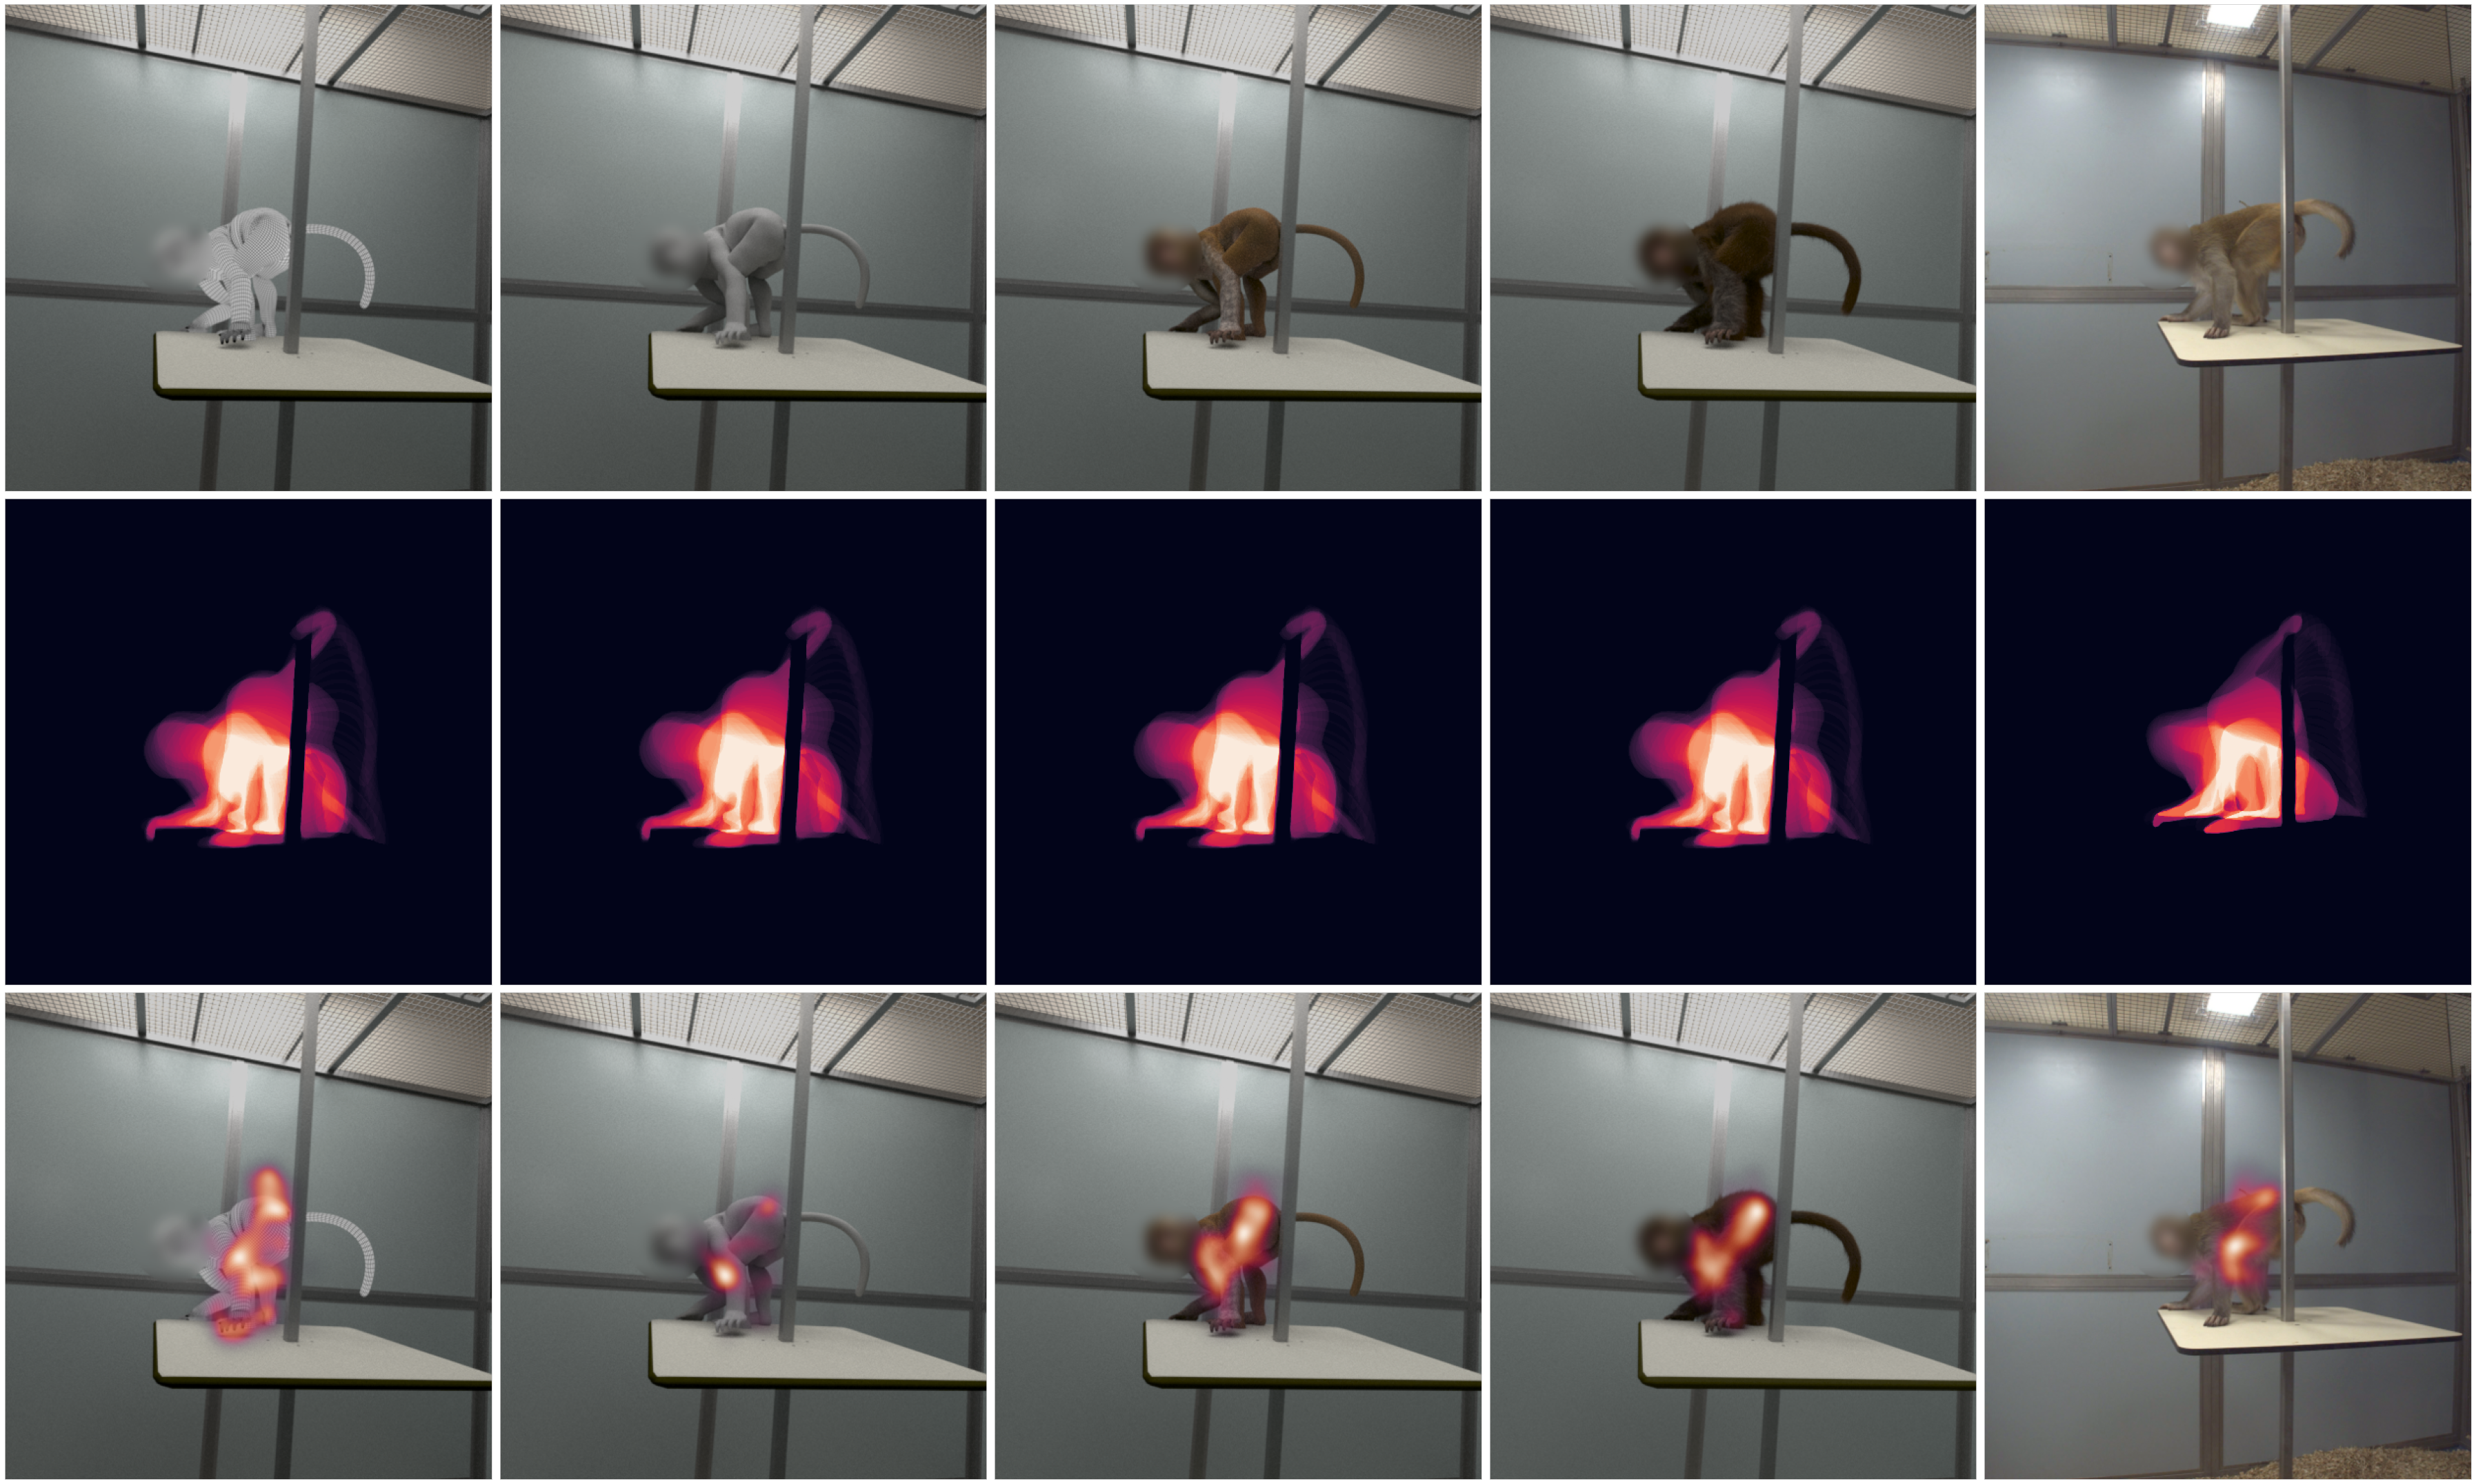

In [6]:
pad_inches = 0.1/8.5
kernel_size = 800
sigma = 9


trial_selection_index = 0
individuals_selection = 0

eye_fixation_filter_index = 2 # 2 is in filter, 0 is in image, 1 is out of image, 3 is out of filter, 4 is all
fix_clustering = 0 #0 or 1

individuals = ["Gin", "Hyde", "Jekyll", "Nacho", "Tonic", "Odin", "Libre", "Cuba"]
actions = ["fear", "walk"]
renders = ["wireframe","gray", "color", "fur", "real"]
views = ["B", "C", "D", "E", "F", "G", "H"]
vid_conds = ['png', 'avi']


trial_selections = ["all", "first", "last", "f5", "f3"]
trial_selection = trial_selections[trial_selection_index]
trial_iter_selection = {}


for ind in individuals:
    if trial_selection == "all":
        trial_iter_selection[ind] = range(trial_caps[ind])
    elif trial_selection == "first":
        trial_iter_selection[ind] = [0]
    elif trial_selection == "last":
        trial_iter_selection[ind] = [trial_caps[ind] - 1]
    elif trial_selection == "f5":
        trial_iter_selection[ind] = range(5)
    elif trial_selection == "f3":
        trial_iter_selection[ind] = range(3)


individuals_selection_options = ["all", "Gin", "Hyde", "Jekyll", "Nacho", "Tonic", "Odin", "Cuba"]
if individuals_selection == 0:
    individuals_plotted = individuals
else:
    individuals_plotted = [individuals[individuals_selection - 1]]
print(f"Individuals we are actually plotting: {individuals_plotted}")


if action == "fear":
    frame_timing = "0035"
else:
    frame_timing = "0010"

# Create over views and actions different conditions

# (2actionsx 7views) rows x (5renders x static/dynamic )  cols
nrows = len(actions) * len(views)
ncols = len(renders) * len(vid_conds)


nrows = 3
ncols = len(renders)


figsize_x_multi_row = 10
figsize_y_multi_row = 10

fig, ax = plt.subplots(nrows=nrows, ncols= ncols, figsize=(figsize_x_multi_row * ncols, figsize_y_multi_row * nrows ))
fig.patch.set_facecolor('white')


image_screen_area = [[290, 790], [710, 1210]]
video_screen_area = [[292, 788], [712, 1208]]


fixation_maps_aggregated = {}

percentage_thresh = 0.2
fixation_coverage = {}


individuals = ["Gin", "Hyde", "Jekyll", "Nacho", "Tonic", "Odin", "Libre", "Cuba"]
actions = ["fear", "walk"]
renders = ["wireframe","gray", "color", "fur", "real"]
views = ["B", "C", "D", "E", "F", "G", "H"]
vid_conds = ['png', 'avi']


actions_red = ["fear"]
views_red = ["B"]
vid_conds_red = ["avi"]


# rows are views and actions
for action_index, action in enumerate(actions_red):
    for view_index, view in enumerate(views_red):
        for dyn_index, dyn in enumerate(vid_conds_red):
            for rend_index, render in enumerate(renders):

                if action == "fear":
                    frame_timing = "0035"
                else:
                    frame_timing = "0010"

                # Get the condition for the image retrieval (use the images for videos as well)
                cond_string_image = f'lm_{action}_{view}_{render}_{frame_timing}.png'

                real_image = images[cond_string_image]


                if dyn == 'png':

                    cond_string = cond_string_image
                    img_size = 500

                else:
                    cond_string = f"lummatch_{action}_{view}_{render}.avi"

                    img_size = 496
                    real_image = resize(real_image, (img_size, img_size, 3))

                # Create probability map
                fixations_as_prob_map = np.zeros((img_size, img_size))

                # Over individuals
                for ind in individuals_plotted:
                    # Over trials
                    for tr in trial_iter_selection[ind]:


                        ind_fixations = individuals_fixations[ind][tr]

                        # Alle fixations
                        fixations = ind_fixations[cond_string][fix_clustering+2][:, :2].astype(int) # +2 in fix clustering
                        durations = ind_fixations[cond_string][fix_clustering+2][:, 6]


                        if eye_fixation_filter_index < 4:
                            # Filter the fixations...
                            fixations_filtered = copy.deepcopy(fixations)
                            fixations_list = ind_fixations[cond_string][fix_clustering][eye_fixation_filter_index]
                            fixations_filtered = fixations_filtered[fixations_list]

                            durations_filtered = copy.deepcopy(durations)
                            durations_filtered = durations_filtered[fixations_list]


                        elif eye_fixation_filter_index == 4:
                            fixations_filtered = fixations
                            durations_filtered = durations

                        # Put gaussians on top
                        for fix_index, fix in enumerate(fixations_filtered):
                            x = fix[0]
                            y = fix[1]

                            amp = durations_filtered[fix_index]

                            if dyn == 'png':

                                x_adj_to_image = x - image_screen_area[1][0] #+ start_image
                                y_adj_to_image = y - image_screen_area[0][0] #+ start_image

                            else:
                                x_adj_to_image = x - video_screen_area[1][0] #+ start_image
                                y_adj_to_image = y - video_screen_area[0][0] #+ start_image

                            ys, xs = get_kernel_img_boundaries(x_adj_to_image, y_adj_to_image, img_size, kernel_size)

                            if ys[2] > 0 and xs[2] >0 and ys[0]<img_size and xs[0]<img_size:

                                fixations_as_prob_map[ys[0]:ys[2], xs[0]:xs[2]] += amp * (1/np.sqrt(2*np.pi*sigma**2)) * gkern(kernel_size, sigma)[ys[1]:ys[3], xs[1]:xs[3]]

                coverage = copy.deepcopy(fixations_as_prob_map)

                # Max is hard to interpret if there
                max_val = coverage.max()
                thresh = max_val * percentage_thresh

                # Rescale densities to have 1 at max point (not in sum though)
                fixations_as_prob_map *= 1/np.max(fixations_as_prob_map)

                # Plot the image without fixations

                plot_col = rend_index
                plot_row = 0

                # First plot the real image
                ax[plot_row, plot_col].imshow(real_image)
                ax[plot_row, plot_col].set_xticks([])
                ax[plot_row, plot_col].set_yticks([])

                plot_row = 1

                if render == 'real':
                     vid_mask_cond = f"lummatch_{action}_{view}_{render}"
                else:
                     vid_mask_cond = f"lummatch_{action}_{view}_fur"

                accumulated_masks = np.sum(vid_masks[vid_mask_cond], axis=0)
                accumulated_masks = resize(accumulated_masks, (img_size, img_size))
                ax[plot_row, plot_col].imshow(accumulated_masks)
                ax[plot_row, plot_col].set_xticks([])
                ax[plot_row, plot_col].set_yticks([])
                # Plot the image with fixations

                plot_col = rend_index
                plot_row = 2

                # First plot the real image
                ax[plot_row, plot_col].imshow(real_image)
                prob_map_image_normalized = ax[plot_row, plot_col].imshow(fixations_as_prob_map, alpha=fixations_as_prob_map)
                ax[plot_row, plot_col].set_xticks([])
                ax[plot_row, plot_col].set_yticks([])

fig.tight_layout()
fig.savefig(join(analysis_path, f"reduced_{individuals_selection_options[individuals_selection]}_{trial_selection}.pdf"), pad_inches=pad_inches, bbox_inches="tight")

## Coverage analysis
Put gaussian kernels on top of fixations, evaluate pixel location values and clip them at a given threshold to end up with the coverage.

In [7]:
if recreate_analysis:

    # Create a dictionary
    df_coverage =  pd.DataFrame(columns=["Coverage","Individual", "Trial", "Masking", "Action", "View", "Video", "Render"])
    
    
    #fixations_dummy = [[200, 100], [230, 300]]
    kernel_size = 800
    sigma = 9
    
    
    multi_dim_without_prefactor = True
    
    for trial_selection_index in range(4):
        print(f"Trial selection index: {trial_selection_index}")
        for individuals_selection in range(len(individuals)+1):
            print(f"Individual selection index: {individuals_selection}")
            for eye_filter_index in range(4):
                print(f"Eye filter index: {eye_filter_index}")
    
    
                trial_selection_index = trial_selection_index
                individuals_selection = individuals_selection
    
    
                eye_filters = ["in_image", "out_image", "in_filter", "out_filter"]
                eye_fixation_filter_index = eye_filter_index # 2 is in filter, 0 is in image, 1 is out of image, 3 is out of filter
                fix_clustering = 0 #0 or 1
    
                individuals = ["Gin", "Hyde", "Jekyll", "Nacho", "Tonic", "Odin", "Libre", "Cuba"]
                actions = ["fear", "walk"]
                renders = ["wireframe","gray", "color", "fur", "real"]
                views = ["B", "C", "D", "E", "F", "G", "H"]
                vid_conds = ['png', 'avi']
    
    
                trial_selections = ["all", "first", "last", "f3"]
                trial_selection = trial_selections[trial_selection_index]
                trial_iter_selection = {}
    
    
                for ind in individuals:
                    if trial_selection == "all":
                        trial_iter_selection[ind] = range(trial_caps[ind])
                    elif trial_selection == "first":
                        trial_iter_selection[ind] = [0]
                    elif trial_selection == "last":
                        trial_iter_selection[ind] = [trial_caps[ind] - 1]
                    #elif trial_selection == "f5":
                    #    trial_iter_selection[ind] = range(5)
                    elif trial_selection == "f3":
                        trial_iter_selection[ind] = range(3)
    
    
                individuals_selection_options = ["all", "Gin", "Hyde", "Jekyll", "Nacho", "Tonic", "Odin", "Libre", "Cuba"]
                if individuals_selection == 0:
                    individuals_plotted = individuals
                else:
                    individuals_plotted = [individuals[individuals_selection - 1]]
    
    
                if action == "fear":
                    frame_timing = "0035"
                else:
                    frame_timing = "0010"
    
                # Create over views and actions different conditions
    
                # (2actionsx 7views) rows x (5renders x static/dynamic )  cols
                nrows = len(actions) * len(views)
                ncols = len(renders) * len(vid_conds)
    
    
                image_screen_area = [[290, 790], [710, 1210]]
                video_screen_area = [[292, 788], [712, 1208]]
    
    
                fixation_maps_aggregated = {}
    
                percentage_thresh = 0.2
                fixation_coverage = {}
    
    
                # rows are views and actions
                for action_index, action in enumerate(actions):
                    for view_index, view in enumerate(views):
                        for dyn_index, dyn in enumerate(vid_conds):
                            for rend_index, render in enumerate(renders):
    
                                if action == "fear":
                                    frame_timing = "0035"
                                else:
                                    frame_timing = "0010"
    
                                # Get the condition for the image retrieval (use the images for videos as well)
                                cond_string_image = f'lm_{action}_{view}_{render}_{frame_timing}.png'
                                real_image = images[cond_string_image]
    
                                if dyn == 'png':
                                    cond_string = cond_string_image
                                    img_size = 500
    
                                else:
                                    cond_string = f"lummatch_{action}_{view}_{render}.avi"
                                    img_size = 496
                                    real_image = resize(real_image, (img_size, img_size, 3))
    
                                # Create probability map
                                fixations_as_prob_map = np.zeros((img_size, img_size))
    
                                # Over individuals
                                for ind in individuals_plotted:
                                    # Over trials
                                    for tr in trial_iter_selection[ind]:
    
    
                                        ind_fixations = individuals_fixations[ind][tr]
    
                                        # Alle fixations
                                        fixations = ind_fixations[cond_string][fix_clustering+2][:, :2].astype(int) # +2 in fix clustering
    
                                        # Filter the fixations...
                                        fixations_filtered = copy.deepcopy(fixations)
                                        fixations_list = ind_fixations[cond_string][fix_clustering][eye_fixation_filter_index]
                                        fixations_filtered = fixations_filtered[fixations_list]
    
    
                                        # Potentiell könnte man auch noch die fixations clustern die lange Zeiten haben
    
                                        # Put gaussians on top
                                        for fix in fixations_filtered:
                                            x = fix[0]
                                            y = fix[1]
    
                                            if dyn == 'png':
    
                                                x_adj_to_image = x - image_screen_area[1][0] #+ start_image
                                                y_adj_to_image = y - image_screen_area[0][0] #+ start_image
    
                                            else:
                                                x_adj_to_image = x - video_screen_area[1][0] #+ start_image
                                                y_adj_to_image = y - video_screen_area[0][0] #+ start_image
    
                                            ys, xs = get_kernel_img_boundaries(x_adj_to_image, y_adj_to_image, img_size, kernel_size)
    
                                            if ys[2] > 0 and xs[2] >0 and ys[0]<img_size and xs[0]<img_size:
    
    
                                                if multi_dim_without_prefactor:
                                                    fixations_as_prob_map[ys[0]:ys[2], xs[0]:xs[2]] += gkern(kernel_size, sigma)[ys[1]:ys[3], xs[1]:xs[3]]
                                                else:
                                                    fixations_as_prob_map[ys[0]:ys[2], xs[0]:xs[2]] += (1/np.sqrt(2*np.pi*sigma**2)) * gkern(kernel_size, sigma)[ys[1]:ys[3], xs[1]:xs[3]]
    
    
                                # For density estimation no clipping!
                                # Clip the image, normally rather
                                #empty_image = np.clip(empty_image, 0, 1)
    
                                coverage = copy.deepcopy(fixations_as_prob_map)
    
                                # In future, some percentage value of biggest values in a heatmap
                                # Threshold as a single gaussian sigma probability
    
                                if multi_dim_without_prefactor:
                                    thresh = np.exp(-0.5)
                                else:
                                    thresh = (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-0.5)
    
                                coverage[coverage<thresh] = 0
    
                                fixation_coverage[cond_string] = np.count_nonzero(coverage)
                                fixation_maps_aggregated[cond_string] = coverage
    
                                df_coverage.loc[len(df_coverage)] = [np.count_nonzero(coverage), individuals_selection_options[individuals_selection], trial_selection,eye_filters[eye_fixation_filter_index] , action, view, dyn, render]
                                
    print("Threshold: ", thresh)
    df_coverage.to_hdf(join(analysis_path, f"coverage_analysis_{t2}_{mindur}_{pixel_offset}.h5"), key='df_coverage', mode='w')
    df_coverage.to_csv(join(analysis_path, f"coverage_analysis_{t2}_{mindur}_{pixel_offset}.csv"))

In [8]:
df_coverage = pd.read_hdf(join(analysis_path, f"coverage_analysis_{t2}_{mindur}_{pixel_offset}.h5"))

## Create a dataframe out of the fixation analysis like the coverage dataframe

In [9]:
# Create a dictionary
df = pd.DataFrame(columns=["FixationsIm", "MeanDurIm", "FixationsMo", "MeanDurMo", "SamplesInImage", "SamplesInMonkey", "Individual", "Trial", "Action", "View", "Video", "Render"])

# Get the dictionary individual fixations

individuals = ["Gin", "Hyde", "Jekyll", "Nacho", "Tonic", "Odin", "Libre", "Cuba"]
actions = ["fear", "walk"]
views = ["B", "C", "D", "E", "F", "G", "H"]
vid_conds = ['png', 'avi']
renders = ["wireframe","gray", "color", "fur", "real"]


eye_fixation_filter_string = ["in_image", "out_image", "in_monkey", "out_monkey"]
#eye_fixation_filter_index = 2 # 2 is in filter, 0 is in image, 1 is out of image, 3 is out of filter
fix_clustering = 0 #0 or 1

for ind in individuals:
    for tr in range(trial_caps[ind]):
        for action_index, action in enumerate(actions):
            for view_index, view in enumerate(views):
                for dyn_index, dyn in enumerate(vid_conds):
                    for rend_index, render in enumerate(renders):


                        if action == "fear":
                            frame_timing = "0035"
                        else:
                            frame_timing = "0010"


                        if dyn == 'png':
                            cond_string = f'lm_{action}_{view}_{render}_{frame_timing}.png'
                        else:

                            cond_string = f"lummatch_{action}_{view}_{render}.avi"


                        fix_by_cond = individuals_fixations[ind][tr][cond_string]


                        filtered_fixation_values = []

                        for filter_index in [0, 2]:

                            # Filter for the number of fixations
                            satisfiying_fixation_indices = fix_by_cond[fix_clustering][filter_index]

                            nb_fix = len(satisfiying_fixation_indices)

                            satisfiying_fixation_indices = fix_by_cond[fix_clustering][filter_index]

                            # Filter also for the
                            fixation_durs_filtered = fix_by_cond[fix_clustering + 2][satisfiying_fixation_indices, 6]

                            if fixation_durs_filtered.__len__() == 0:
                                #print(fix_by_cond[fix_clustering + 2][:, 6])
                                mean_dur = np.NAN
                            else:
                                mean_dur = fix_by_cond[fix_clustering + 2][satisfiying_fixation_indices, 6].mean()

                            filtered_fixation_values.append(nb_fix)
                            filtered_fixation_values.append(mean_dur/2000)

                        sample_counts = fix_by_cond[6]

                        df.loc[len(df)] = [filtered_fixation_values[0], filtered_fixation_values[1], filtered_fixation_values[2], filtered_fixation_values[3], sample_counts[0], sample_counts[1], ind, tr, action, view, dyn, render]
                        #df_dur.loc[len(df_dur)] = [mean_dur, ind, tr, action, view, dyn, render]

df.to_csv(join(analysis_path, f"fixations_{t2}_{mindur}_{pixel_offset}.csv"))

# Plots from the paper

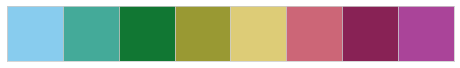

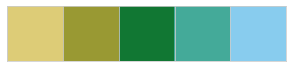

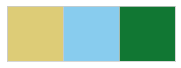

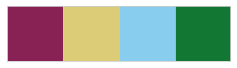

In [10]:
# Color palette from
# https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40 , third link
# https://personal.sron.nl/~pault/

# Muted color scheme, from cyan to purple
muted = ["#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
muted_palette = sb.color_palette(muted, muted.__len__())
sb.palplot(muted_palette)

render_palette = muted[:5][::-1]
custom_palette_render = sb.color_palette(render_palette, render_palette.__len__())
sb.palplot(custom_palette_render)


boxplot_palette = [render_palette[0], render_palette[4], render_palette[2]]
custom_palette_boxplot = sb.color_palette(boxplot_palette, boxplot_palette.__len__())
sb.palplot(custom_palette_boxplot)

lineplot_middle_palette = [muted[-2], render_palette[0], render_palette[4], render_palette[2]]
custom_lineplot_middle_palette= sb.color_palette(lineplot_middle_palette, lineplot_middle_palette.__len__())
sb.palplot(custom_lineplot_middle_palette)

gray_color_sb = '#292929'
#gray_color_sb = '#666666'
# Light scheme but needs a dark background
#light = ["#77AADD", "#99DDFF", "#44BB99", "#BBCC33", "#AAAA00", "#EEDD88", "#EE8866", "#FFAABB"]
#custom_palette_render = sb.color_palette(light, light.__len__())
#sb.palplot(custom_palette_render)

In [11]:
def p_to_stars(p):
    if p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return 'ns'  # ns = not significant


In [12]:
# Save path
save_path = analysis_path
save_path = join(analysis_path, "plots")

if not os.path.exists(save_path):
    os.makedirs(save_path)

# Overall changes
sb.set_context("paper")
# Adjust the background
sb.set(style='darkgrid')

# Markersize mean
marker_size_mean = "13"
fontsize_label_axis_major = 30
fontsize_label_axis_minor = 20
padding_major_axis = 20
fliersize = 8
p_value_font_size = 40

sb.set(rc={"lines.linewidth": 1.5})


# Markersize mean
marker_size_mean = "26"
fontsize_label_axis_major = 55
fontsize_label_axis_minor = 55
padding_major_axis = 30
fliersize = 8
p_value_font_size = 65

line_width = 10
boxplot_line_width = 8
line_widht_pointplot = 6

sb.set(rc={"lines.linewidth": line_width})

# for 18cm figures
# Markersize mean
marker_size_mean = f"{26/8.5}"
fontsize_label_axis_major = 5.2
fontsize_label_axis_minor = 5.2
padding_major_axis = 23/8.5
fliersize = 8/8.5
p_value_font_size = 65/8.5

line_width = 10/8.5
boxplot_line_width = 8/8.5
line_widht_pointplot = 6/8.5

legend_size = 30/8.5
capsize = .1/8.5
pad_inches = 0.1/8.5

MINOR_PAD = -5

sb.set(rc={"lines.linewidth": line_width})

figsize_x = 15/8.5
figsize_y = 15/8.5

analysis_path_save_base = save_path

In [13]:
def y_axis_p_values_adjustment(df, ax, pvalues, corresponding_xs, p_value_font_size=p_value_font_size, factor = 6, ymax_adj_factor = 4, adjust_height=1, extension=0, custom_max_start_reduction = 0, text_offset=0):

    ## P values -----------------
    # Get the yticks
    y_axis_ticks = ax.get_yticks()
    diff_ticks = y_axis_ticks[1] - y_axis_ticks[0]


    corresponding_ys = []
    max_y_tick_start = df[value].max()

    max_tick_index = np.argmax(y_axis_ticks > max_y_tick_start)

    # Retrieve the value at the found index
    max_y_tick_start = y_axis_ticks[max_tick_index]

    print(f"{diff_ticks}")

    # First y
    for i in range(pvalues.__len__()):

        y_ls = [max_y_tick_start - custom_max_start_reduction + i*diff_ticks/2 * adjust_height - diff_ticks/factor, diff_ticks/factor * extension, '#292929']
        corresponding_ys.append(y_ls)

    annots_stats = []
    for pvalue in pvalues:
        annots_stats.append(p_to_stars(pvalue))

    for index, (x1, x2) in enumerate(corresponding_xs):

        y, h, col = corresponding_ys[index]

        if pvalues[index] <= 0.05:

            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=None, c=col)
            ax.text((x1+x2)*.5, y+text_offset, annots_stats[index], ha='center', va='bottom', color=col, fontsize=p_value_font_size, fontweight="bold")

    # Readjustment of the y axis
    ymin, ymax = ax.get_ylim()
    new_ymin = ymin
    new_ymax = ymax + diff_ticks/ymax_adj_factor
    ax.set_ylim(new_ymin, new_ymax)

    return ax, new_ymin, new_ymax

In [14]:
def adjust_ticks_and_labels_uniformly(ax, x_labels, fontsize_ylabel, labelpad_ylabel, fontsize_ticks_both, minor_pad=MINOR_PAD):
    # Change the labels etc.
    # Change the names of the axis accordingly to what it should be in the paper
    ax.set_xticklabels(x_labels)
    # Change y label in size and pad it to the y axis
    ax.set_ylabel(value, fontsize=fontsize_ylabel, labelpad=labelpad_ylabel)
    # Remove x label
    ax.set_xlabel("", fontsize=0, labelpad=0)
    # Change size of the axis ticks for x and y axis
    ax.tick_params(axis='both', labelsize=fontsize_ticks_both, pad= minor_pad)

    return ax

In [15]:
df_coverage

Coverage Individual Trial     Masking Action View Video     Render
0         43378        all   all    in_image   fear    B   png  wireframe
1         52846        all   all    in_image   fear    B   png       gray
2         46856        all   all    in_image   fear    B   png      color
3         50251        all   all    in_image   fear    B   png        fur
4         49941        all   all    in_image   fear    B   png       real
...         ...        ...   ...         ...    ...  ...   ...        ...
20155      3845       Cuba    f3  out_filter   walk    H   avi  wireframe
20156      3228       Cuba    f3  out_filter   walk    H   avi       gray
20157       512       Cuba    f3  out_filter   walk    H   avi      color
20158      3113       Cuba    f3  out_filter   walk    H   avi        fur
20159      4854       Cuba    f3  out_filter   walk    H   avi       real

[20160 rows x 8 columns]

Conditions for testing: Render and Video
[('wireframe', None), ('gray', None), ('color', None), ('fur', None), ('real', None)]
Data file named: Coverage_Render_first_0_in_image.csv
None
Single Factors
SpherResults(spher=True, W=0.3907136611011824, chi2=5.090476689061762, dof=9, pval=0.8357710416467372)
  Contrast      A          B  Paired  Parametric         T  dof alternative  \
0   Render  color        fur    True        True -0.875365  7.0   two-sided   
1   Render  color       gray    True        True  2.164366  7.0   two-sided   
2   Render  color       real    True        True -3.655930  7.0   two-sided   
3   Render  color  wireframe    True        True  0.027715  7.0   two-sided   
4   Render    fur       gray    True        True  2.375132  7.0   two-sided   
5   Render    fur       real    True        True -2.431285  7.0   two-sided   
6   Render    fur  wireframe    True        True  0.826973  7.0   two-sided   
7   Render   gray       real    True        True -5.037826  7.0 

C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)



500.0


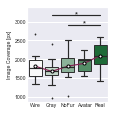

In [16]:
# 1. First Trial Coverage in image
RENDER_LABELS = ["Wire", "Gray", "NoFur", "Avatar", "Real"]

major_cond = 'Render'
order = renders
var1 = renders

#order = None
side_cond2 = 'Action'
var2 = None #actions

value = 'Coverage'
trials = 'first'

#trials = "all"
masking= 'in_image'
#masking= 'in_filter'

plotnumber = 1
plot_save_path = join(analysis_path_save_base, f"{plotnumber}")
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)


# Get the means across individuals
res, df_pg = mean_aggregation_individuals_rm_anova(df_coverage, value=value, var1=var1, trial=trials, inds=individuals, coverage=True, masking=masking, pixel_offset=pixel_offset, analysis_path=plot_save_path)

# Create the plot
fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
fig.patch.set_facecolor('white')
mean_dict = {"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":marker_size_mean}

plotting_parameters = {
    'data':    df_pg,
    'x':       major_cond,
    'y':       value,
    'order': order,
    'ax': ax,
    'palette': "blend:#f9f9f9,#117733",
    'fliersize':fliersize,
    'showmeans':True,
    'meanprops':mean_dict,
'linewidth': boxplot_line_width}

# Plot with seaborn
sb.boxplot(**plotting_parameters)
sb.lineplot(data=df_pg.groupby("Render").mean().loc[order], y=f"{value}", x=f"{major_cond}", ax=ax, linewidth=line_width, color = custom_lineplot_middle_palette[0])


if trials == "first":
    # Start with lower first
    pvalues = [0.015, 0.041]
    corresponding_xs = [[1, 4], [2, 4]]
    # Change order here
    pvalues = pvalues[::-1]
    corresponding_xs = corresponding_xs[::-1]
else:
    # Start with lower first
    pvalues = [0.009, 0.0002, 0.0008, 0.0005]
    corresponding_xs = [[0, 4], [1, 4], [2, 4], [3, 4]]
    # Change order here
    pvalues = pvalues[::-1]
    corresponding_xs = corresponding_xs[::-1]


text_offset = -35
ax, new_ymin, new_ymax = y_axis_p_values_adjustment(df_pg, ax, pvalues, corresponding_xs, text_offset=text_offset)
ax = adjust_ticks_and_labels_uniformly(ax, RENDER_LABELS, fontsize_label_axis_major, padding_major_axis, fontsize_label_axis_minor)

ax.set_ylabel("Image Coverage [px]")
for line in ax.lines:
    line.set_linewidth(line_width)
fig.tight_layout()
fig.savefig(join(plot_save_path, f"{value}_{major_cond}_{trials}_{masking}_{pixel_offset}.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches="tight")

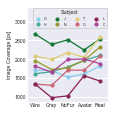

In [17]:
# 2. All single individuals first trial in image for coverage

plotnumber = 2
plot_save_path = join(analysis_path_save_base, f"{plotnumber}")
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)
fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
fig.patch.set_facecolor('white')


with plt.rc_context({'lines.linewidth': line_widht_pointplot}):
    # Make another line plot in the last axis
    sb.pointplot(data=df_pg, x=major_cond,y=value,hue="Individual", ax= ax, capsize=capsize, palette=muted_palette)
ax = adjust_ticks_and_labels_uniformly(ax, RENDER_LABELS, fontsize_label_axis_major, padding_major_axis, fontsize_label_axis_minor)
ax.set_ylim(new_ymin, new_ymax)

# Increase labels of the legend
plt.setp(ax.get_legend().get_texts(), fontsize=fontsize_label_axis_minor) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=fontsize_label_axis_minor) # for legend title


handles, labels = ax.get_legend_handles_labels()

# Reduce the labels only to the first letter of their name
labels = [l[0] for l in labels]

ax.legend(handles=handles, labels=labels, prop={'size': legend_size}, fontsize=fontsize_label_axis_major, ncol=4, title="Subject", title_fontsize=fontsize_label_axis_minor )
ax.set_ylabel("Image Coverage [px]")

# Tight layout and save
fig.tight_layout()
fig.savefig(join(plot_save_path, f"{value}_{major_cond}_{trials}_{masking}_{pixel_offset}_over_individuals.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches="tight")

First trial
Conditions for testing: Render and Video
[('wireframe', 'png'), ('wireframe', 'avi'), ('gray', 'png'), ('gray', 'avi'), ('color', 'png'), ('color', 'avi'), ('fur', 'png'), ('fur', 'avi'), ('real', 'png'), ('real', 'avi')]
FIRST TRIAL RESULTS!!!
Data file named: FixationsIm_Render_Video_0_0_in_filter.csv
png
Multiple Factor
           Source         SS  ddof1  ddof2         MS         F     p-unc  \
0          Render  16.206250      4     28   4.051562  7.028877  0.000475   
1           Video  18.390880      1      7  18.390880  7.079195  0.032435   
2  Render * Video   0.949362      4     28   0.237341  0.440262  0.778419   

   p-GG-corr       ng2       eps  
0   0.002246  0.100000  0.718627  
1   0.032435  0.111971  1.000000  
2   0.698203  0.006467  0.641959  
Conditions for testing: Render and Video
[('wireframe', None), ('gray', None), ('color', None), ('fur', None), ('real', None)]
FIRST TRIAL RESULTS!!!


C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.14771377349638035, 0.1477196932714716, 0.14769785020884812)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.1, 0.1, 0.1)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Data file named: FixationsIm_Render_0_0_in_filter.csv
None
Single Factors
SpherResults(spher=True, W=0.2675754002453423, chi2=7.141083529059656, dof=9, pval=0.6399073169945224)
  Contrast      A          B  Paired  Parametric         T  dof alternative  \
0   Render  color        fur    True        True -0.846841  7.0   two-sided   
1   Render  color       gray    True        True  1.841002  7.0   two-sided   
2   Render  color       real    True        True -3.767591  7.0   two-sided   
3   Render  color  wireframe    True        True -0.373444  7.0   two-sided   
4   Render    fur       gray    True        True  2.412929  7.0   two-sided   
5   Render    fur       real    True        True -3.054418  7.0   two-sided   
6   Render    fur  wireframe    True        True  0.435079  7.0   two-sided   
7   Render   gray       real    True        True -5.783319  7.0   two-sided   
8   Render   gray  wireframe    True        True -2.923495  7.0   two-sided   
9   Render   real  wireframe    T

C:\Users\Lucas\AppData\Local\Temp\ipykernel_38592\2078373169.py:108: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.tight_layout()
C:\Users\Lucas\AppData\Local\Temp\ipykernel_38592\2078373169.py:108: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.tight_layout()
C:\Users\Lucas\AppData\Local\Temp\ipykernel_38592\2078373169.py:109: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.savefig(join(plot_save_path, f"{value}_{major_cond}_{vid}_{trials}_{fix_clustering}_{t2}_{mindur}_{pixel_offset}.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches=

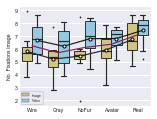

In [18]:
# 3.All trial nb fixations in monnkey as boxplots next to each other
## Over Videos
%matplotlib inline
# Plotting conditions
n_plots = trial_caps.__len__() + 3
ncols = 1


major_cond = 'Render'
order = renders
#order = None
value = 'FixationsIm'
#value = "FixationsIm"

trials = 1#1
individuals = ["Gin", "Hyde", "Jekyll", "Nacho", "Tonic", "Odin", "Libre", "Cuba"]


plotnumber = 3
plot_save_path = join(analysis_path_save_base, f"{plotnumber}")
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)
# Convert this for aggregation function
trials_reduction = 0
if trials != 1: # then it's over all

    trials_reduction = -1
else:
    print("First trial")

vid = None #'avi'# 'avi'

var2_string="Video"
var2 = vid_conds
increase_width_factor = 1.3
fig, ax = plt.subplots(figsize=(figsize_x * increase_width_factor, figsize_y))
fig.patch.set_facecolor('white')


# Make a boxplot across individuals
# Assign axis
axis = ax

# Get the means across individuals
res, df_pg = mean_aggregation_individuals_rm_anova(df, value=value, var1=renders, var2=vid_conds, trial=trials_reduction, inds=individuals, coverage=False, tr_caps=trial_caps, pixel_offset=pixel_offset, analysis_path=plot_save_path)

plotting_parameters = {
    'data':    df_pg,
    'x':       major_cond,
    'y':       value,
    'hue': var2_string,
    'order': order,
    'ax': axis,
    'palette': custom_palette_boxplot,
    'fliersize':fliersize,
    'showmeans':True,
    'meanprops':mean_dict,
'linewidth': boxplot_line_width,
'boxprops':{'edgecolor':gray_color_sb}}


# Make a boxplot of it with seaborn
ax = sb.boxplot(**plotting_parameters)

#for box in ax.artists:
#    box.set_edgecolor(gray_color_sb)
flierlist_offsets = []
for i in range(5*2):
    flierlist_offsets.append(6 + i*7)

for index, line in enumerate(ax.lines):

    line.set_color(gray_color_sb)

    if index in flierlist_offsets:
        line.set_color(gray_color_sb)
        line.set_mec(gray_color_sb)
        line.set_mfc(gray_color_sb)

sb.lineplot(data=df_pg.groupby("Render").mean().loc[order], y=f"{value}", x=f"{major_cond}", ax=axis, linewidth=line_width, color = custom_lineplot_middle_palette[0])

# from: https://stackoverflow.com/questions/67975303/how-to-connect-boxplots-with-a-mean-line
# Divide the default range of .8 with -.8/len(hue)
connect_dots = sb.pointplot(data=df_pg, x='Render', y=value, hue='Video', errorbar=None, ci=None,
              dodge=.8 - .8 / 2, scale=1, color='k', label=None, ax=axis, markers='')

#plt.legend(prop={'size': 45})
handles, labels = axis.get_legend_handles_labels()
axis.legend(handles=handles[:4], labels=["Image", "Video"], prop={'size': legend_size}, fontsize=fontsize_label_axis_major)

# Change the size back
for line in axis.lines:
    line.set_linewidth(line_width)
    #line.set_color(gray_color_sb)
    #print(line.get_color())

# Calculate non-parametric friedmans anova
res, df_pg = mean_aggregation_individuals_rm_anova(df, value=value, var1=renders, trial=trials_reduction, inds=individuals, coverage=False, tr_caps=trial_caps, pixel_offset=pixel_offset, analysis_path=plot_save_path)

pingouin_to_friedman_anova_(df_pg, value, renders)


ax = adjust_ticks_and_labels_uniformly(ax, RENDER_LABELS, fontsize_label_axis_major, padding_major_axis, fontsize_label_axis_minor)

ax.set_ylabel("No. Fixations Image")

# Save the figure
fig.tight_layout()
fig.savefig(join(plot_save_path, f"{value}_{major_cond}_{vid}_{trials}_{fix_clustering}_{t2}_{mindur}_{pixel_offset}.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches="tight")


First trial
Conditions for testing: Render and Video
[('wireframe', 'png'), ('wireframe', 'avi'), ('gray', 'png'), ('gray', 'avi'), ('color', 'png'), ('color', 'avi'), ('fur', 'png'), ('fur', 'avi'), ('real', 'png'), ('real', 'avi')]
FIRST TRIAL RESULTS!!!
Data file named: FixationsMo_Render_Video_0_0_in_filter.csv
png
Multiple Factor
           Source         SS  ddof1  ddof2         MS         F     p-unc  \
0          Render  11.472577      4     28   2.868144  4.295280  0.007795   
1           Video  17.712309      1      7  17.712309  5.063098  0.059187   
2  Render * Video   0.928954      4     28   0.232239  0.792061  0.540270   

   p-GG-corr       ng2       eps  
0   0.023214  0.081835  0.634757  
1   0.059187  0.120960  1.000000  
2   0.497650  0.007165  0.648337  
Conditions for testing: Render and Video
[('wireframe', None), ('gray', None), ('color', None), ('fur', None), ('real', None)]
FIRST TRIAL RESULTS!!!
Data file named: FixationsMo_Render_0_0_in_filter.csv
None
Singl

C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.14771377349638035, 0.1477196932714716, 0.14769785020884812)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\seaborn\categorical.py:1781: UserWarning: You passed a edgecolor/edgecolors ((0.1, 0.1, 0.1)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
C:\Users\Lucas\AppData\Local\Temp\ipykernel

SpherResults(spher=True, W=0.256713851083757, chi2=7.365546685829102, dof=9, pval=0.6172927897087515)
  Contrast      A          B  Paired  Parametric         T  dof alternative  \
0   Render  color        fur    True        True -1.102287  7.0   two-sided   
1   Render  color       gray    True        True  2.736750  7.0   two-sided   
2   Render  color       real    True        True -0.266411  7.0   two-sided   
3   Render  color  wireframe    True        True  1.872204  7.0   two-sided   
4   Render    fur       gray    True        True  3.126845  7.0   two-sided   
5   Render    fur       real    True        True  0.319252  7.0   two-sided   
6   Render    fur  wireframe    True        True  2.189262  7.0   two-sided   
7   Render   gray       real    True        True -2.425859  7.0   two-sided   
8   Render   gray  wireframe    True        True -1.361838  7.0   two-sided   
9   Render   real  wireframe    True        True  1.752521  7.0   two-sided   

      p-unc    p-corr p-adju

C:\Users\Lucas\AppData\Local\Temp\ipykernel_38592\1415533164.py:109: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.savefig(join(plot_save_path, f"{value}_{major_cond}_{vid}_{None}_{trials}_{fix_clustering}_{t2}_{mindur}_{pixel_offset}.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches="tight")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_38592\1415533164.py:109: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.savefig(join(plot_save_path, f"{value}_{major_cond}_{vid}_{None}_{trials}_{fix_clustering}_{t2}_{mindur}_{pixel_offset}.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches="tight")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_38592\1415533164.py:109: MatplotlibDeprecationWarnin

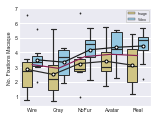

In [19]:
# 3.All trial nb fixations in monnkey as boxplots next to each other

## Over Videos

%matplotlib inline
# Plotting conditions
n_plots = trial_caps.__len__() + 3
ncols = 1


major_cond = 'Render'
order = renders
#order = None
value = 'FixationsMo'
#value = "FixationsIm"


# First trial is for 0
trials = 1#0#1

# Convert this for aggregation function
trials_reduction = 0
if trials != 1: # then it's over all

    trials_reduction = -1
else:
    print("First trial")
# all trials is something else like 1
plotnumber = 4
plot_save_path = join(analysis_path_save_base, f"{plotnumber}")
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)
individuals = ["Gin", "Hyde", "Jekyll", "Nacho", "Tonic", "Odin", "Libre", "Cuba"]

vid = None #'avi'# 'avi'

var2_string="Video"
var2 = vid_conds

fig, ax = plt.subplots(figsize=(figsize_x * increase_width_factor, figsize_y))
fig.patch.set_facecolor('white')


# Make a boxplot across individuals
# Assign axis
axis = ax

# Get the means across individuals
res, df_pg = mean_aggregation_individuals_rm_anova(df, value=value, var1=renders, var2=vid_conds, trial=trials_reduction, inds=individuals, coverage=False, tr_caps=trial_caps, pixel_offset=pixel_offset, analysis_path=plot_save_path)

plotting_parameters = {
    'data':    df_pg,
    'x':       major_cond,
    'y':       value,
    'hue': var2_string,
    'order': order,
    'ax': axis,
    'palette': custom_palette_boxplot,
    'fliersize':fliersize,
    'showmeans':True,
    'meanprops':mean_dict,
'linewidth': boxplot_line_width,
'boxprops':{'edgecolor':gray_color_sb}}


# Make a boxplot of it with seaborn
sb.boxplot(**plotting_parameters)

flierlist_offsets = []

for i in range(5*2):
    flierlist_offsets.append(6 + i*7)

for index, line in enumerate(ax.lines):

    line.set_color(gray_color_sb)

    if index in flierlist_offsets:
        line.set_color(gray_color_sb)
        line.set_mec(gray_color_sb)
        line.set_mfc(gray_color_sb)
sb.lineplot(data=df_pg.groupby("Render").mean().loc[order], y=f"{value}", x=f"{major_cond}", ax=axis, linewidth=line_width, color = custom_lineplot_middle_palette[0])

# from: https://stackoverflow.com/questions/67975303/how-to-connect-boxplots-with-a-mean-line
# Divide the default range of .8 with -.8/len(hue)
connect_dots = sb.pointplot(data=df_pg, x='Render', y=value, hue='Video', errorbar=None, ci=None,
              dodge=.8 - .8 / 2, scale=1, color='k', label=None, ax=axis, markers='')


handles, labels = axis.get_legend_handles_labels()
axis.legend(handles=handles[:4], labels=["Image", "Video"], prop={'size': legend_size}, fontsize=fontsize_label_axis_major)

# Change the size back
for line in axis.lines:
    line.set_linewidth(line_width)

# Calculate non-parametric friedmans anova
res, df_pg = mean_aggregation_individuals_rm_anova(df, value=value, var1=renders, trial=trials_reduction, inds=individuals, coverage=False, tr_caps=trial_caps, pixel_offset=pixel_offset, analysis_path=plot_save_path)

pingouin_to_friedman_anova_(df_pg, value, renders)


ax = adjust_ticks_and_labels_uniformly(ax, RENDER_LABELS, fontsize_label_axis_major, padding_major_axis, fontsize_label_axis_minor)

ax.set_ylabel("No. Fixations Macaque")

# Save the figure
fig.tight_layout()
fig.savefig(join(plot_save_path, f"{value}_{major_cond}_{vid}_{None}_{trials}_{fix_clustering}_{t2}_{mindur}_{pixel_offset}.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches="tight")


Conditions for testing: Render and Video
[('wireframe', None), ('gray', None), ('color', None), ('fur', None), ('real', None)]
ALL TRIAL RESULTS!!!
Data file named: MeanDurIm_Render_-1_0_in_filter.csv
None
Single Factors
SpherResults(spher=True, W=3879812.862521978, chi2=-82.17786134527408, dof=9, pval=1.0)
  Contrast      A          B  Paired  Parametric         T  dof alternative  \
0   Render  color        fur    True        True  0.526529  7.0   two-sided   
1   Render  color       gray    True        True -2.410750  7.0   two-sided   
2   Render  color       real    True        True  3.193678  7.0   two-sided   
3   Render  color  wireframe    True        True -0.933258  7.0   two-sided   
4   Render    fur       gray    True        True -2.390954  7.0   two-sided   
5   Render    fur       real    True        True  2.796393  7.0   two-sided   
6   Render    fur  wireframe    True        True -1.115726  7.0   two-sided   
7   Render   gray       real    True        True  3.618396 

C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Data file named: MeanDurIm_Render_Video_-1_0_in_filter.csv
png
Multiple Factor
           Source        SS  ddof1  ddof2        MS         F     p-unc  \
0          Render  0.059490      4     28  0.014873  7.218620  0.000398   
1           Video  0.024486      1      7  0.024486  5.557102  0.050538   
2  Render * Video  0.002704      4     28  0.000676  1.346579  0.277519   

   p-GG-corr       ng2       eps  
0   0.006723  0.054686  0.507098  
1   0.050538  0.023257  1.000000  
2   0.286434  0.002622  0.744103  


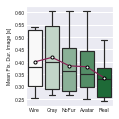

In [20]:
# 5. All trial mean durations
## Over Videos

%matplotlib inline
# Plotting conditions
n_plots = trial_caps.__len__() + 3
ncols = 1


major_cond = 'Render'
order = renders
#order = None
value = 'MeanDurMo'
value = 'MeanDurIm'
#var2_string="Video"

plotnumber = 5
plot_save_path = join(analysis_path_save_base, f"{plotnumber}")
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)
# switch between 0 and 1
trials = 0
# Convert this for aggregation function
trials_reduction = 0
if trials != 1: # then it's over all
    trials_reduction = -1

vid =None# 'avi'

fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
fig.patch.set_facecolor('white')

axis = ax

# Get the means across individuals, also for first level
res, df_pg = mean_aggregation_individuals_rm_anova(df, value=value, var1=renders, var2=[None], trial=trials_reduction, inds=individuals, coverage=False, tr_caps=trial_caps, pixel_offset=pixel_offset, analysis_path=plot_save_path)

pingouin_to_friedman_anova_(df_pg, value, renders)

# Get the means across individuals, if splitting up for video conditions, to check for anova as well
_, _ = mean_aggregation_individuals_rm_anova(df, value=value, var1=renders, var2=vid_conds, trial=trials_reduction, inds=individuals, coverage=False, tr_caps=trial_caps, pixel_offset=pixel_offset, analysis_path=plot_save_path)

plotting_parameters = {
    'data':    df_pg,
    'x':       major_cond,
    'y':       value,
    'order': order,
    'ax': axis,
    'palette': "blend:#f9f9f9,#117733",
    'fliersize':fliersize,
    'showmeans':True,
    'meanprops':mean_dict}

# Make a boxplot of it with seaborn
sb.boxplot(**plotting_parameters)
for line in axis.lines:
    #line.set_linewidth(line_width)
    line.set_color(gray_color_sb)
sb.lineplot(data=df_pg.groupby("Render").mean().loc[order], y=f"{value}", x=f"{major_cond}", ax=axis, linewidth=line_width, color = custom_lineplot_middle_palette[0])

ax = adjust_ticks_and_labels_uniformly(ax, RENDER_LABELS, fontsize_label_axis_major, padding_major_axis, fontsize_label_axis_minor)

if value ==  'MeanDurMo':
    ax.set_ylabel("Mean Fix. Dur. Macaque [s]")
else:
    ax.set_ylabel("Mean Fix. Dur. Image [s]")

for line in axis.lines:
    line.set_linewidth(line_width)

# Save the figure
fig.tight_layout()
fig.savefig(join(plot_save_path, f"{value}_{major_cond}_{vid}_{None}_{trials}_{fix_clustering}_{t2}_{mindur}_{pixel_offset}.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches="tight")

Conditions for testing: Combined_Renders and Action
[('wireframe_png', 'fear'), ('wireframe_png', 'walk'), ('gray_png', 'fear'), ('gray_png', 'walk'), ('color_png', 'fear'), ('color_png', 'walk'), ('fur_png', 'fear'), ('fur_png', 'walk'), ('real_png', 'fear'), ('real_png', 'walk'), ('wireframe_avi', 'fear'), ('wireframe_avi', 'walk'), ('gray_avi', 'fear'), ('gray_avi', 'walk'), ('color_avi', 'fear'), ('color_avi', 'walk'), ('fur_avi', 'fear'), ('fur_avi', 'walk'), ('real_avi', 'fear'), ('real_avi', 'walk')]
FIRST TRIAL RESULTS!!!
Data file named: FixationsMo_Combined_Renders_Action_0_0_in_filter.csv
fear
Multiple Factor
                      Source         SS  ddof1  ddof2         MS          F  \
0           Combined_Renders  60.227679      9     63   6.691964   4.101519   
1                     Action  30.750128      1      7  30.750128  53.083168   
2  Combined_Renders * Action   3.383801      9     63   0.375978   0.569154   

      p-unc  p-GG-corr       ng2       eps  
0  0.00034

C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


2.0


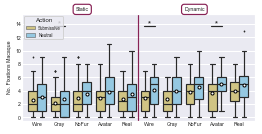

In [21]:
# 6. Fixations for the different actions to show that they can be differentiated easily

# Combine video and render into a new unique column with features
df_comb = copy.deepcopy(df)
df_comb["Combined_Renders"] = df["Render"] + '_' + df["Video"]
# Comparing video valley against static valley
# Plotting conditions

major_cond = 'Combined_Renders'
value = 'FixationsMo'

order = df_comb["Combined_Renders"].unique().tolist()

var1 = order
var2 = actions

side_cond2 = "Action"

plotnumber = 6
plot_save_path = join(analysis_path_save_base, f"{plotnumber}")
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)


trials = 1
# Reduce dataset to only a certain individual, videos, over rendertypes

if trials == 1:
    red_df_vid = reduce_df_by_conditions(df_comb, trials=trials)
else:
    red_df_vid = df_comb


# Convert this for aggregation function
trials_reduction = 0
if trials != 1: # then it's over all
    trials_reduction = -1

red_df_vid.to_csv(join(plot_save_path, f"{trials}_combined_df.csv"))

fig, ax = plt.subplots(figsize = (figsize_x * 2, figsize_y))
fig.patch.set_facecolor('white')


#ax.boxplot(render_twice, positions=positions)
plotting_parameters = {
    'data':    red_df_vid,
    'x':       major_cond,
    'y':       value,
    'hue': side_cond2,
    'order': order,
    'ax': ax,
    'palette': custom_palette_boxplot,
    'fliersize':fliersize,
    'showmeans':True,
    'meanprops':mean_dict,
'boxprops':{'edgecolor':gray_color_sb},
'flierprops':{'color':gray_color_sb}}

# Make a boxplot of it with seaborn
ax = sb.boxplot(**plotting_parameters)


flierlist_offsets = []

for i in range(20):
    flierlist_offsets.append(6 + i*7)

for index, line in enumerate(ax.lines):

    line.set_color(gray_color_sb)

    if index in flierlist_offsets:
        line.set_color(gray_color_sb)
        line.set_mec(gray_color_sb)
        line.set_mfc(gray_color_sb)

render_twice = copy.deepcopy(RENDER_LABELS)
render_twice.extend(RENDER_LABELS)

# Get the means across individuals
res, df_pg = mean_aggregation_individuals_rm_anova(red_df_vid, value=value, var1=var1, var2=var2, trial=trials_reduction, inds=individuals, coverage=False, tr_caps=trial_caps, pixel_offset=pixel_offset, var2_string=side_cond2, var1_string=major_cond, analysis_path=plot_save_path)

# Condition, Variable, W Wert, n reduced, p val, CLES

wilcox_dataframe = pd.DataFrame(columns=["Subset", "group1", "group2", "statistic", "n", "p-val", "CLES"])

p_values = []
for type_comb in order:
    print("Combination: ", type_comb)

    comb_red_df = reduce_df_by_conditions(df_pg, render_comb=type_comb)
    # Then differ between actions

    x = comb_red_df[comb_red_df["Action"] == "fear"]["FixationsMo"].to_numpy()
    y = comb_red_df[comb_red_df["Action"] == "walk"]["FixationsMo"].to_numpy()

    print(f"Number of ties: ", 8 - np.count_nonzero(x- y))

    wilcox_res = pg.wilcoxon(x, y, alternative='two-sided', correction=True)
    print(wilcox_res)

    p_values.append(wilcox_res["p-val"].values[0])



    seperator_index = str.find(type_comb, "_")

    cond1 = type_comb[:seperator_index]
    cond2 = type_comb[seperator_index+1:]
    variable_condition = side_cond2

    wilcox_dataframe.loc[len(wilcox_dataframe)] = [type_comb, "Submissive", "Neutral", wilcox_res["W-val"].values[0], np.count_nonzero(x- y),  wilcox_res["p-val"].values[0], wilcox_res["CLES"].values[0]]

# Save dataframe as LaTeX table with fixed number of decimal places
latex_output = wilcox_dataframe.to_latex(float_format="%.4f")

# Write output to a file
with open(join(plot_save_path, 'wilcox.tex'), 'w') as f:
    f.write(latex_output)


x1 = np.arange(len(p_values)) - 0.25
x2 = np.arange(len(p_values)) + 0.25
combined_xs = np.vstack((x1, x2)).T

corresponding_xs = combined_xs.tolist()


ax = adjust_ticks_and_labels_uniformly( ax, render_twice, fontsize_label_axis_major, padding_major_axis, fontsize_label_axis_minor)

ax.set_ylabel("No. Fixations Macaque")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:4], labels=["Submissive", "Neutral"], title=side_cond2, prop={'size': legend_size+ 8/8.5}, fontsize=fontsize_label_axis_minor, title_fontsize=fontsize_label_axis_minor + 8/8.5)


plt.axvline(x=4.5, color = custom_lineplot_middle_palette[0], linewidth=line_width)
text_vertical_value = 16.2

ax.text(2,text_vertical_value, "Static", fontsize=fontsize_label_axis_major,  ha='center', va='center', bbox=dict(facecolor='none', edgecolor=custom_lineplot_middle_palette[0], boxstyle='round,pad=0.5', linewidth=line_width))
#ax.text(7,13, "Dynamic", fontsize=fontsize_label_axis_major,  ha='center', va='center')
ax.text(7,text_vertical_value, "Dynamic", fontsize=fontsize_label_axis_major,  ha='center', va='center', bbox=dict(facecolor='none', edgecolor=custom_lineplot_middle_palette[0], boxstyle='round,pad=0.5', linewidth=line_width))

ax, new_ymin, new_ymax = y_axis_p_values_adjustment(red_df_vid, ax, p_values, corresponding_xs, adjust_height=0, custom_max_start_reduction=0)
ax.set_ylim(-0.5, 15.5)

# Save the fig
fig.tight_layout(rect=[-0.03, -0.06, 1.03, 1.05])
fig.savefig(join(plot_save_path, f"{major_cond}_{None}_{trials}_{fix_clustering}_{t2}_{mindur}_{pixel_offset}.pdf"), format="pdf")

Conditions for testing: View and Action
[('B', None), ('C', None), ('D', None), ('E', None), ('F', None), ('G', None), ('H', None)]
FIRST TRIAL RESULTS!!!
Data file named: FixationsMo_View_0_0_in_filter.csv
None
Single Factors
SpherResults(spher=True, W=0.029124259982934164, chi2=16.895100261822748, dof=20, pval=0.7474720573536253)
   Contrast  A  B  Paired  Parametric         T  dof alternative     p-unc  \
0      View  B  C    True        True  0.350029  7.0   two-sided  0.736612   
1      View  B  D    True        True  1.527525  7.0   two-sided  0.170471   
2      View  B  E    True        True  4.247725  7.0   two-sided  0.003804   
3      View  B  F    True        True  5.120346  7.0   two-sided  0.001368   
4      View  B  G    True        True  2.659524  7.0   two-sided  0.032490   
5      View  B  H    True        True  4.360893  7.0   two-sided  0.003311   
6      View  C  D    True        True  0.784098  7.0   two-sided  0.458689   
7      View  C  E    True        True  3.0

C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)



Conditions for testing: View and Action
[('B', 'fear'), ('B', 'walk'), ('C', 'fear'), ('C', 'walk'), ('D', 'fear'), ('D', 'walk'), ('E', 'fear'), ('E', 'walk'), ('F', 'fear'), ('F', 'walk'), ('G', 'fear'), ('G', 'walk'), ('H', 'fear'), ('H', 'walk')]
FIRST TRIAL RESULTS!!!
Data file named: FixationsMo_View_Action_0_0_in_filter.csv
fear
Multiple Factor
          Source         SS  ddof1  ddof2         MS          F     p-unc  \
0           View  20.069821      6     42   3.344970   8.184180  0.000007   
1         Action  21.525089      1      7  21.525089  53.083168  0.000165   
2  View * Action  13.563036      6     42   2.260506   6.173678  0.000105   

   p-GG-corr       ng2       eps  
0   0.000242  0.122597  0.628605  
1   0.000165  0.130328  1.000000  
2   0.001903  0.086279  0.587087  
View:  B
Number of ties:  0
          W-val alternative     p-val       RBC      CLES
Wilcoxon    7.0   two-sided  0.148438 -0.611111  0.359375
View:  C
Number of ties:  0
          W-val alternat

C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Lucas\miniforge-pypy3\envs\MacAction\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


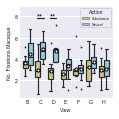

In [22]:
# 7. Viewpoints over actions to show that this differs

## Over Actions
%matplotlib inline
# Plotting conditions
n_plots = trial_caps.__len__() + 3
ncols = 1


major_cond = 'View'
var1 = views
order = views
#order = None
value = 'FixationsMo'
trials = 1

side_cond2 = 'Action'
var2 = actions

plotnumber = 7
plot_save_path = join(analysis_path_save_base, f"{plotnumber}")
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)
# Convert this for aggregation function
trials_reduction = 0
if trials != 1: # then it's over all
    trials_reduction = -1

vid =None# 'avi'

fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
fig.patch.set_facecolor('white')

axis = ax

# Get the means across individuals
res, df_pg = mean_aggregation_individuals_rm_anova(df, value=value, var1=var1, trial=trials_reduction, inds=individuals, coverage=False, tr_caps=trial_caps, pixel_offset=pixel_offset, var2_string=side_cond2, var1_string=major_cond, analysis_path=plot_save_path)

# Get the means across individuals
res, df_pg = mean_aggregation_individuals_rm_anova(df, value=value, var1=var1, var2=var2, trial=trials_reduction, inds=individuals, coverage=False, tr_caps=trial_caps, pixel_offset=pixel_offset, var2_string=side_cond2, var1_string=major_cond, analysis_path=plot_save_path)

plotting_parameters = {
    'data':    df_pg,
    'x':       major_cond,
    'y':       value,
    'hue': side_cond2,
    'order': order,
    'ax': axis,
    'palette': custom_palette_boxplot,
    'fliersize':fliersize,
    'showmeans':True,
    'meanprops':mean_dict,
'boxprops':{'edgecolor':gray_color_sb}}

# Make a boxplot of it with seaborn
sb.boxplot(**plotting_parameters)

flierlist_offsets = []

for i in range(7*2):
    flierlist_offsets.append(6 + i*7)

for index, line in enumerate(ax.lines):

    line.set_color(gray_color_sb)

    if index in flierlist_offsets:
        line.set_color(gray_color_sb)
        line.set_mec(gray_color_sb)
        line.set_mfc(gray_color_sb)

handles, labels = axis.get_legend_handles_labels()
axis.legend(handles=handles[:4], labels=["Submissive", "Neutral"], title=side_cond2, prop={'size': legend_size}, fontsize=fontsize_label_axis_minor, title_fontsize=fontsize_label_axis_minor)

# Change the size back
for line in axis.lines:
    line.set_linewidth(line_width)


ax = adjust_ticks_and_labels_uniformly(ax, views, fontsize_label_axis_major, padding_major_axis, fontsize_label_axis_minor)
ax.set_ylabel("No. Fixations Macaque")

ax.set_xlabel(f"View", fontsize=fontsize_label_axis_major, labelpad=padding_major_axis)

wilcox_dataframe = pd.DataFrame(columns=["Subset", "group1", "group2", "statistic", "n", "p-val", "CLES"])

p_values = []

# Test it with pinguoin wilxocon
for view in views:
    print("View: ", view)
    view_red_df = reduce_df_by_conditions(df_pg, view=view)
    x = view_red_df[view_red_df["Action"] == "fear"]["FixationsMo"].to_numpy()
    y = view_red_df[view_red_df["Action"] == "walk"]["FixationsMo"].to_numpy()

    print(f"Number of ties: ", 8 - np.count_nonzero(x- y))

    wilcox_res = pg.wilcoxon(x, y, alternative='two-sided', correction=True)
    print(wilcox_res)

    p_values.append(wilcox_res["p-val"].values[0])
    wilcox_dataframe.loc[len(wilcox_dataframe)] = [f"View-{view}", "Submissive", "Neutral", wilcox_res["W-val"].values[0], np.count_nonzero(x- y),  wilcox_res["p-val"].values[0], wilcox_res["CLES"].values[0]]

# Save dataframe as LaTeX table with fixed number of decimal places
latex_output = wilcox_dataframe.to_latex(float_format="%.4f")

# Write output to a file
with open(join(plot_save_path, 'wilcox.tex'), 'w') as f:
    f.write(latex_output)

x1 = np.arange(len(p_values)) - 0.25
x2 = np.arange(len(p_values)) + 0.25
combined_xs = np.vstack((x1, x2)).T
corresponding_xs = combined_xs.tolist()

ax, new_ymin, new_ymax = y_axis_p_values_adjustment(df_pg, ax, p_values, corresponding_xs, adjust_height=0)#, factor=1, ymax_adj_factor=1)

# Increase a bit the y axis lim
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax+0.5)


# Save the figure
fig.tight_layout()
fig.savefig(join(plot_save_path, f"{major_cond}_{vid}_{None}_{trials}_{fix_clustering}_{t2}_{mindur}_{pixel_offset}.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches="tight")

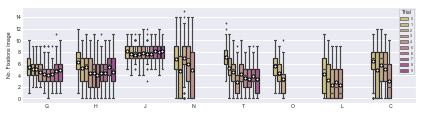

In [23]:
# Reduce dataset to only a certain individual, videos, over rendertypes

plotnumber = 8
plot_save_path = join(analysis_path_save_base, f"{plotnumber}")
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)
fig, ax = plt.subplots(figsize = (figsize_x*4, figsize_y))
fig.patch.set_facecolor('white')


major_cond="Individual"
value="FixationsIm"
side_cond2 = "Trial"

plotting_parameters = {
    'data':    df,
    'x':       major_cond,
    'y':       value,
    'hue': side_cond2,
    'ax': ax,
    'palette': "blend:#DDCC77,#AA4499",
    'fliersize':fliersize,
    'showmeans':True,
    'meanprops':mean_dict,
'boxprops':{'edgecolor':gray_color_sb}}


# Make a boxplot of it with seaborn
sb.boxplot(**plotting_parameters)

#sb.boxplot(data=df, x='Individual', y='FixationsIm', hue="Trial", ax=ax, color='skyblue', showmeans=True,
#           meanprops={"marker":"o",
#                       "markerfacecolor":"white",
#                       "markeredgecolor":"black",
#                      "markersize":"10"})

#fig.suptitle("Number of fixations over trials for particular individuals", fontsize=30)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title=side_cond2, prop={'size': legend_size}, fontsize=fontsize_label_axis_minor, title_fontsize=fontsize_label_axis_minor)

# Change the size back
for line in axis.lines:
    line.set_linewidth(line_width)




ax = adjust_ticks_and_labels_uniformly(ax, [l[0] for l in individuals], fontsize_label_axis_major, padding_major_axis, fontsize_label_axis_minor)
ax.set_ylabel("No. Fixations Image")

fig.savefig(join(plot_save_path, f"{major_cond}_{vid}_{None}_{trials}_{fix_clustering}_{t2}_{mindur}_{pixel_offset}.pdf"), format="pdf", pad_inches=pad_inches, bbox_inches="tight")